<a href="https://colab.research.google.com/github/AnguieGarciaB/topicosanalitica/blob/main/notebook/P1_MovieGenrePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Movie Genre Classification**


Estudiantes:

*  ANGUIE GARCIA
*  MILI GALINDO
*  SONIA RAMÍREZ
*  LOURDES RODIL




Classify a movie genre based on its plot.

<img src="https://raw.githubusercontent.com/sergiomora03/AdvancedTopicsAnalytics/main/notebooks/img/moviegenre.png"
     style="float: left; margin-right: 10px;" />



### **Data**

Input:
- movie plot

Output:
Probability of the movie belong to each genre


### Evaluation

- 30% Report with all the details of the solution, the analysis and the conclusions. The report cannot exceed 10 pages, must be send in PDF format and must be self-contained.
- 30% Code with the data processing and models developed that support the reported results.
- 30% Presentation of no more than 15 minutes with the main results of the project.
- 10% Model performance achieved. Metric: "AUC".

• The project must be carried out in groups of 4 people.
• Use clear and rigorous procedures.
• The delivery of the project is on March 15th, 2024, 11:59 pm, through email with Github link.
• No projects will be received after the delivery time or by any other means than the one established.




### Acknowledgements

We thank Professor Fabio Gonzalez, Ph.D. and his student John Arevalo for providing this dataset.

See https://arxiv.org/abs/1702.01992

In [1]:
!pip install tensorflow-hub
!pip install tensorflow
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.5/257.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.0 MB/s eta 0:00:00


# **Fase 1 - Adquision de los Datos**

In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer

Se obtiene dos dataset con la información de peliculas que incluye: Titulo, Plot, Año de estreno de la pelicula, genero de la pelicula (multiclase) y rating:

In [3]:
dataTraining = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [4]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [5]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


### Definición de X:
A continuación se realiza una exploración de la columna *"plot"* del dataset *"Training"* y se asigna a un dataset denominado X

In [6]:
X = dataTraining['plot']
X

3107    most is the story of a single father who takes...
900     a serial killer decides to teach the secrets o...
6724    in sweden ,  a female blackmailer with a disfi...
4704    in a friday afternoon in new york ,  the presi...
2582    in los angeles ,  the editor of a publishing h...
                              ...                        
8417    " our marriage ,  their wedding .  "  it ' s l...
1592    the wandering barbarian ,  conan ,  alongside ...
1723    like a tale spun by scheherazade ,  kismet fol...
7605    mrs .  brisby ,  a widowed mouse ,  lives in a...
215     tinker bell journey far north of never land to...
Name: plot, Length: 7895, dtype: object

El dataset de training contiene 7.895 registros:

In [7]:
X.shape

(7895,)

### Definición de Y:

 Aplica una función lambda a cada elemento de la columna 'genres':

In [8]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))

In [9]:
dataTraining['genres']

3107                                       [Short, Drama]
900                               [Comedy, Crime, Horror]
6724                         [Drama, Film-Noir, Thriller]
4704                                              [Drama]
2582                            [Action, Crime, Thriller]
                              ...                        
8417                                    [Comedy, Romance]
1592                         [Action, Adventure, Fantasy]
1723       [Adventure, Musical, Fantasy, Comedy, Romance]
7605    [Animation, Adventure, Drama, Family, Fantasy,...
215               [Animation, Adventure, Family, Fantasy]
Name: genres, Length: 7895, dtype: object

Utilizando MultiLabelBinarizer() se convierte la lista de etiquetas en una representación binaria:

In [10]:
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])
y_genres

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])

## **Análisis Descriptivo de los datos**

### **a. Matriz de Correlación de Generos**

Al analizar la matriz de correlación entre los géneros de películas se observa que la mayor correlación positiva es entre “Familia” y “Animation” con un 0.5 y la mayor correlación negativa es entre “Triller” y “Comedy” con un -0.3:

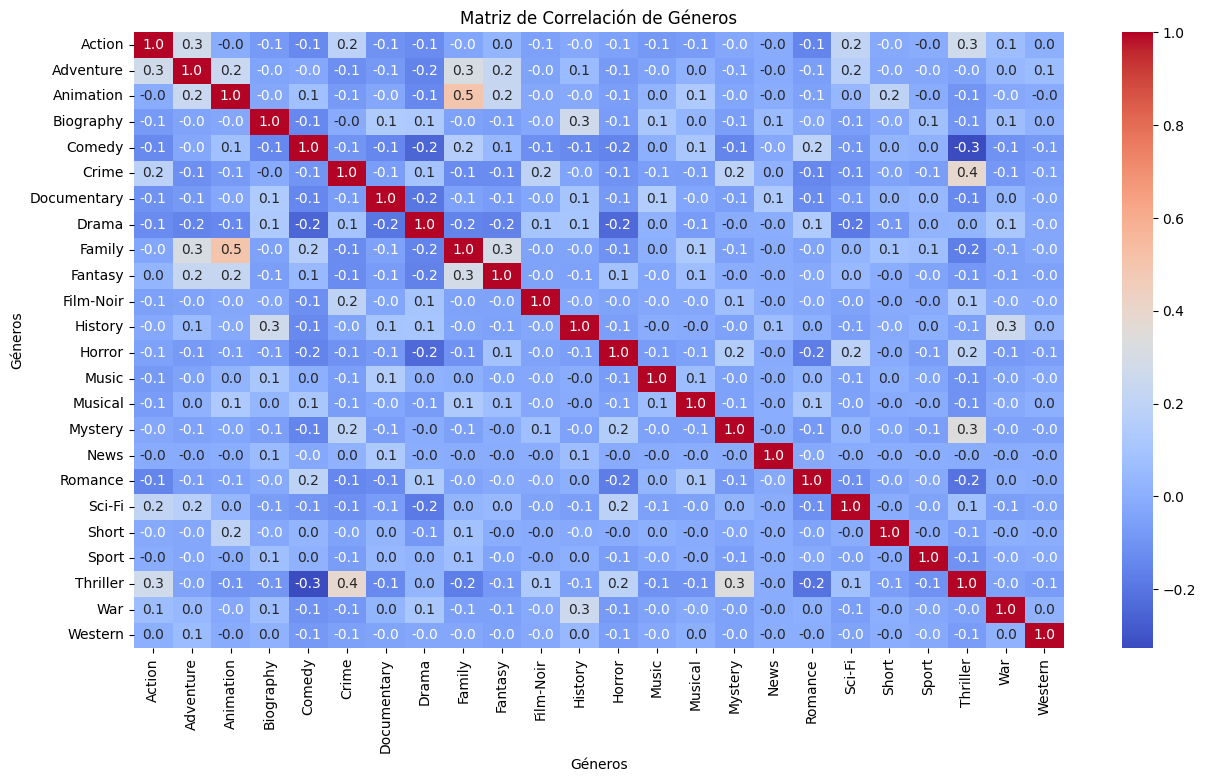

In [11]:
df_genres = pd.DataFrame(y_genres, columns=le.classes_)
correlation_matrix = df_genres.corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Matriz de Correlación de Géneros')
plt.xlabel('Géneros')
plt.ylabel('Géneros')
plt.show()

El identifica que el tamaño de dataset "Y_genders" esta compuesto por 24 columnas asocidas a cada genero (variables binarias):

In [12]:
y_genres.shape

(7895, 24)

### **b. Histograma de Frecuencias de Géneros**

Al observar el histograma de frecuencia de los géneros, se observa que el género más frecuente es el de "Drama", con 3.965 películas, seguido de "Comedia" con 3.046. Vale la pena destacar, que una película puede tener más de un género, por lo que la predicción deberá considerar esta situación.

<ipython-input-13-a9542a42a0c6>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=le.classes_, y=genre_counts, palette='viridis')


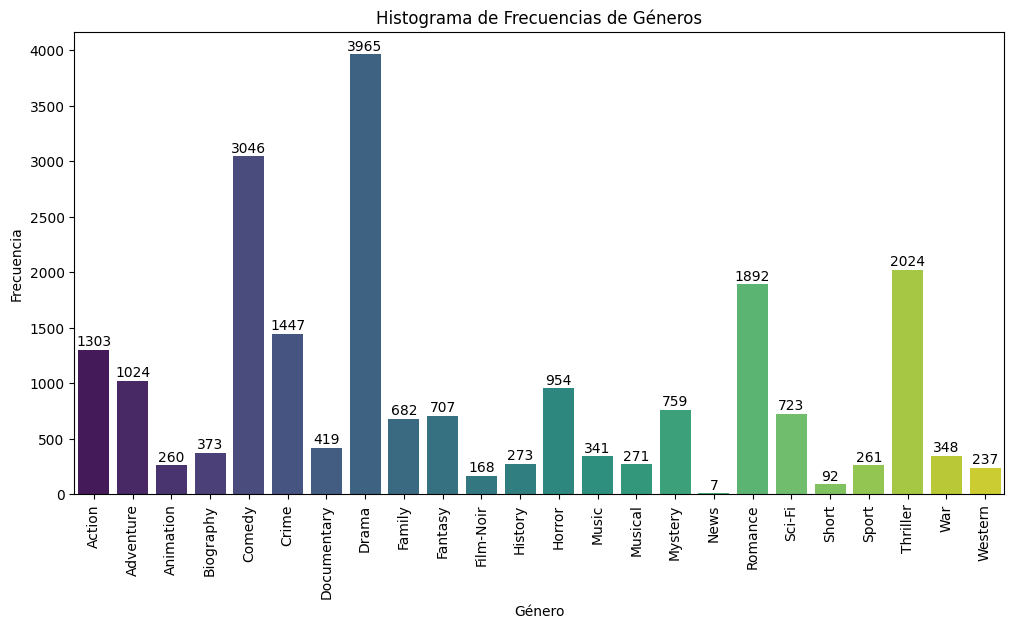

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

genre_counts = y_genres.sum(axis=0)
plt.figure(figsize=(12, 6))
sns.barplot(x=le.classes_, y=genre_counts, palette='viridis')
plt.title('Histograma de Frecuencias de Géneros')
plt.xlabel('Género')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)

# Añadir etiquetas de datos en las barras
for i, count in enumerate(genre_counts):
    plt.text(i, count + 10, str(count), ha='center', va='bottom')

plt.show()

### **c. Histograma de frecuencias de años en las películas**

Al analizar la información por año se observa que la distribución de los datos es asimétrica hacia la derecha o positivamente sesgada, con lo cual se establece igualmente que hay mayor número de películas en los últimos 30 años.

<Axes: xlabel='year', ylabel='Count'>

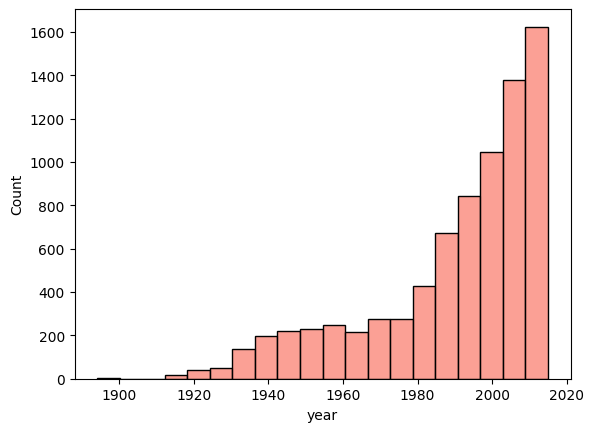

In [14]:
sns.histplot(data=dataTraining, x='year',binwidth=6.0, color='salmon' )

### **d. Histograma de frecuencias de ratings de películas**

Al evaluar la distribución del rating de las películas del dataset de training se observa una concentración entre 6 y 8:

<Axes: xlabel='rating', ylabel='Count'>

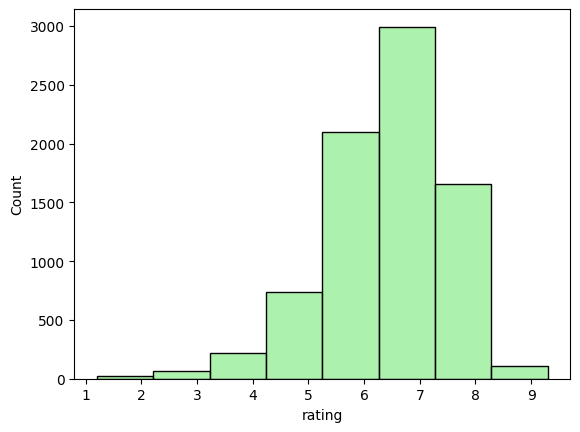

In [15]:
sns.histplot(data=dataTraining, x='rating',binwidth=1.0, color='lightgreen' )

# **Fase 2 - Limpieza del texto**

Para el proyecto no fueron requeridas labores de limpieza de la base de datos, previo al paso de procesamiento, ya que no se evidenciaron datos nulos.

# **Fase 3 - Preprocesamiento del Texto**

En la etapa de preprocesamiento se aplicaron las siguientes técnicas:

### **a. Stemming**

Se aplicó el algoritmo de “Snowball” (Porter, 2023) para procesar los documentos del dataset para reducir variantes morfológicas de las formas de una palabra a raíces comunes o lexemas y obtener una lista de las raíces de los documentos. Adicionalmente, se ajustan los documentos a minúsculas, se eliminan los caracteres que no sea una letra o un número, los signos de puntuación.

Se realiza un proceso de vectorización de texto utilizando la técnica TF-ID donde se ignorarán las palabras que aparecen en más del 70% de los documentos dado que al muy comunes y no aportarían mucha información.


In [16]:
# initialize stemmer
stemmer = SnowballStemmer('english')
import re

def tokenize_and_stem(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join(text.split())
    tokens = [word for word in nltk.word_tokenize(text)]
    stems = [stemmer.stem(token) for token in tokens]
    return stems

In [17]:
!pip install nltk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [75]:
vect = TfidfVectorizer(max_df=0.7,max_features=5000,stop_words='english', tokenizer=tokenize_and_stem)
X_dtm_stemming = vect.fit_transform(dataTraining['plot'])
print(X_dtm_stemming.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev'

(7895, 5000)


In [76]:
# Obtener el tamaño del vocabulario
len(vect.vocabulary_)

5000

### **b. Lemmatization**

Se utilizo el algoritmo de “WordNetLemmatizer” (Loper, 2023) para procesar los documentos del dataset reducir las formas flexivas/variantes a la forma base y obtener una lista:

In [19]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
import nltk
import string
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [20]:
lemmatizer = WordNetLemmatizer()
# define a function that accepts text and returns a list of lemmas
def split_into_lemmas(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    words = [word for word in nltk.word_tokenize(text)]
    return [lemmatizer.lemmatize(word) for word in words]

In [73]:
vect = TfidfVectorizer(stop_words='english',analyzer=split_into_lemmas)
X_dtm_lemmatization = vect.fit_transform(dataTraining['plot'])
print(X_dtm_lemmatization.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


(7895, 34553)


In [74]:
# Obtener el tamaño del vocabulario
len(vect.vocabulary_)

34553

# **Fase 4 - Preprocesamiento del Texto**

### **a. Embeddings**###
Se utiliza un modelo de aprendizaje profundo pre-entrenado desarrollado por Google que permite codificar oraciones en vectores de alta dimensión (Universal Sentence Encoder - USE, versión 4). Se aplica el modelo al campo “plot” en los dataset de entrenamiento y testing y las convierte en vectores de características semánticas.

In [22]:
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [23]:
def remove_stopwords(text):
    # Tokenizar el texto
    tokens = text.split()
    # Remover stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

def stem_tokens(tokens):
    # Stemming de las palabras
    stemmer = SnowballStemmer('english')
    tokens = [stemmer.stem(word) for word in tokens]
    return tokens

In [24]:
def processing(text):
    text = text.lower() # Convertir texto a minúsculas
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text) # Remover caracteres que no sean letras ni números
    text = re.sub(r'[^\w\s]', '', text) # Remover signos de puntuación
    tokens = remove_stopwords(text)  # Remover stop words
    tokens = stem_tokens(tokens) # Stemming de las palabras
    processed_text = ' '.join(tokens) # Unir los tokens nuevamente en texto
    return processed_text

In [25]:
dataTraining["clean"] = dataTraining["plot"].apply(processing)
dataTesting["clean"] = dataTesting["plot"].apply(processing)

In [26]:
dataTraining["clean"]

3107    stori singl father take eight year old son wor...
900     serial killer decid teach secret satisfi caree...
6724    sweden femal blackmail disfigur facial scar me...
4704    friday afternoon new york presid tredway corpo...
2582    los angel editor publish hous carol hunnicut g...
                              ...                        
8417    marriag wed lesson number one newli engag coup...
1592    wander barbarian conan alongsid goofi rogu pal...
1723    like tale spun scheherazad kismet follow remar...
7605    mrs brisbi widow mous live cinder block childr...
215     tinker bell journey far north never land patch...
Name: clean, Length: 7895, dtype: object

In [27]:
dataTraining["clean"].isnull().sum() # verifico si existen nulos

0

#### Libreria Tensorflow

In [28]:
import tensorflow as tf
import tensorflow_hub as hub

In [29]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder/4'
use_embed = hub.load(module_url)

In [30]:
train_embe_plot = use_embed(dataTraining['plot'])
test_embe_plot = use_embed(dataTesting['plot'])

In [31]:
train_embe_clean = use_embed(dataTraining['clean'])
test_embe_clean = use_embed(dataTesting['clean'])

### **b. Análisis de sentimiento**

Se utiliza la biblioteca “textblob” para calcular la polaridad del sentimiento para cada token en training y agregar características adicionales a los datos de entrenamiento. La polaridad del sentimiento es un valor numérico que oscila entre -1 y 1, donde valores negativos indican sentimientos negativos, valores positivos indican sentimientos positivos, y 0 indica neutralidad.

In [32]:
from textblob import TextBlob
dataTraining['sentimiento'] = dataTraining['plot'].apply(lambda texto: TextBlob(texto).sentiment.polarity)

Se crea una matriz de características combinadas que incluye características derivadas del análisis de texto, así como características relacionadas con el año de lanzamiento, rating y análisis de sentimientos.

In [33]:
from scipy.sparse import hstack
text_data = dataTraining['plot']

X_years = np.array(dataTraining['year']).reshape(-1, 1)
X_rating = np.array(dataTraining['rating']).reshape(-1, 1)
X_sentimiento = np.array(dataTraining['sentimiento']).reshape(-1, 1)
X_combined_stemming = hstack([X_dtm_stemming, X_years, X_sentimiento,X_rating])
X_combined_lemmatization = hstack([X_dtm_lemmatization, X_years, X_sentimiento,X_rating])

### **c. Embeddings**

Se combina los embeddings con información adicional sobre las películas (año, calificación, polaridad del sentimiento) en una matriz X_combined, y transforma las etiquetas de género en una matriz binaria y_genres para su uso en el modelo de clasificación:

In [34]:
X_combined_embeddings = np.concatenate([train_embe_plot, dataTraining[['year', 'rating', 'sentimiento']].values],axis=1)
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

# **Fase 5 - Modelación**

Para el modelamiento, se tomaron dos bases, una de train y una de test. Luego, a través de la función de train_test_Split de Sckit Learn, se designó el 67% de los datos de para el entrenamiento y el restante 33% se reservó para realizar las pruebas locales.

# *Modelos con Stemming*

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X_dtm_stemming, y_genres, test_size=0.33, random_state=42)

### **Random Forest Classifier**
Parametros: n_jobs=-1, n_estimators=150, max_depth=15

In [36]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=150, max_depth=15, random_state=42))
clf.fit(X_train, y_train)
y_pred_genres = clf.predict_proba(X_test)
roc_auc_score(y_test, y_pred_genres, average='macro')

0.8295184831640876

### **XGBoost binary:logistic**
Parametros: objective='binary:logistic

In [37]:
import xgboost as xgb
model = xgb.XGBClassifier(objective='binary:logistic')
model.fit(X_train, y_train)
y_pred_genres = clf.predict_proba(X_test)
roc_auc_score(y_test, y_pred_genres, average='macro')

0.8295184831640876

### **XGBoost OneVsRestClassifier**
Parametros: default

In [38]:
from xgboost import XGBClassifier
clf = OneVsRestClassifier(XGBClassifier())
clf.fit(X_train, y_train)
y_pred_genres = clf.predict_proba(X_test)
roc_auc_score(y_test, y_pred_genres, average='macro')

0.8265745563015193

### **XGBoost OneVsRestClassifier parameters**
Parametros: n_jobs=-1, n_estimators=100,learning_rate=0.3, max_depth=5

In [39]:
from xgboost import XGBClassifier
clf = OneVsRestClassifier(XGBClassifier(n_jobs=-1, n_estimators=100,learning_rate=0.3, max_depth=5, random_state=42))
clf.fit(X_train, y_train)
y_pred_genres = clf.predict_proba(X_test)
roc_auc_score(y_test, y_pred_genres, average='macro')

0.8292945046490807

### **Red neuronal**
Parametros por defecto.

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics

# Limpiar la sesión de TensorFlow
tf.keras.backend.clear_session()

In [41]:
# Definir el número de clases
num_classes = y_train.shape[1]
num_classes

24

In [ ]:
# Crear el modelo de red neuronal
model = Sequential()

# Agregar capas al modelo
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  # Usar 'softmax' para problemas de clasificación multiclase

# Compilar el modelo
metric = [metrics.AUC(from_logits=True, multi_label=True)]
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=metric)

# Entrenar el modelo

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Predecir las probabilidades de las clases en el conjunto de prueba
y_pred_prob = model.predict(X_test)
# Calcular el AUC
auc = roc_auc_score(y_test, y_pred_prob, average='macro')
print(f'AUC: {auc}')

### **Support Vector Machine**
Parametros por defecto.

In [52]:
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier

svm_clf = SVC()
multi_output_clf = MultiOutputClassifier(svm_clf)
multi_output_clf.fit(X_train, y_train)
y_pred = multi_output_clf.predict(X_test)
roc_auc_score(y_test, y_pred, average='macro')

0.5618016332057341

# *Modelos con Lemmatization*

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_dtm_lemmatization, y_genres, test_size=0.33, random_state=42)

### **Random Forest Classifier**
Parametros: n_jobs=-1, n_estimators=150, max_depth=15

In [54]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=150, max_depth=15, random_state=42))
clf.fit(X_train, y_train)
y_pred_genres = clf.predict_proba(X_test)
roc_auc_score(y_test, y_pred_genres, average='macro')

0.8186896415496223

### **XGBoost binary:logistic**
Parametros: objective='binary:logistic

In [55]:
import xgboost as xgb
model = xgb.XGBClassifier(objective='binary:logistic')
model.fit(X_train, y_train)
y_pred_genres = clf.predict_proba(X_test)
roc_auc_score(y_test, y_pred_genres, average='macro')

0.8186898983570742

### **XGBoost OneVsRestClassifier**
Parametros por defecto

In [56]:
from xgboost import XGBClassifier
clf = OneVsRestClassifier(XGBClassifier())
clf.fit(X_train, y_train)
y_pred_genres = clf.predict_proba(X_test)
roc_auc_score(y_test, y_pred_genres, average='macro')

0.7973237631160718

### **XGBoost OneVsRestClassifier parameters**
Parametros: n_jobs=-1, n_estimators=100,learning_rate=0.3, max_depth=5

In [57]:
from xgboost import XGBClassifier
clf = OneVsRestClassifier(XGBClassifier(n_jobs=-1, n_estimators=100,learning_rate=0.3, max_depth=5, random_state=42))
clf.fit(X_train, y_train)
y_pred_genres = clf.predict_proba(X_test)
roc_auc_score(y_test, y_pred_genres, average='macro')

0.8030268938027522

### **Red neuronal**
Parametros por defecto.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics

# Limpiar la sesión de TensorFlow
tf.keras.backend.clear_session()

In [ ]:
# Definir el número de clases
num_classes = y_train.shape[1]
num_classes

In [ ]:
# Crear el modelo de red neuronal
model = Sequential()

# Agregar capas al modelo
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  # Usar 'softmax' para problemas de clasificación multiclase

# Compilar el modelo
metric = [metrics.AUC(from_logits=True, multi_label=True)]
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=metric)

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Predecir las probabilidades de las clases en el conjunto de prueba
y_pred_prob = model.predict(X_test)
# Calcular el AUC
auc = roc_auc_score(y_test, y_pred_prob, average='macro')
print(f'AUC: {auc}')

### **Support Vector Machine**
Parametros por defecto.


In [79]:
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier

svm_clf = SVC()
multi_output_clf = MultiOutputClassifier(svm_clf)
multi_output_clf.fit(X_train, y_train)
y_pred = multi_output_clf.predict(X_test)
roc_auc_score(y_test, y_pred, average='macro')

0.5409659868109183

# *Modelos con Embeddings*

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X_combined_embeddings, y_genres, test_size=0.33, random_state=42)

### **Random Forest Classifier**
Parametros: n_jobs=-1, n_estimators=150, max_depth=15

In [66]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=150, max_depth=15, random_state=42))
clf.fit(X_train, y_train)
y_pred_genres = clf.predict_proba(X_test)
roc_auc_score(y_test, y_pred_genres, average='macro')

0.8705714601743134

### **XGBoost binary:logistic**
Parametros: objective='binary:logistic

In [67]:
import xgboost as xgb
model = xgb.XGBClassifier(objective='binary:logistic')
model.fit(X_train, y_train)
y_pred_genres = clf.predict_proba(X_test)
roc_auc_score(y_test, y_pred_genres, average='macro')

0.8705714601743134

### **XGBoost OneVsRestClassifier**
Parametros por defecto

In [68]:
from xgboost import XGBClassifier
clf = OneVsRestClassifier(XGBClassifier())
clf.fit(X_train, y_train)
y_pred_genres = clf.predict_proba(X_test)
roc_auc_score(y_test, y_pred_genres, average='macro')

0.9010052371436901

### **XGBoost OneVsRestClassifier**
Parametros: n_jobs=-1, n_estimators=100,learning_rate=0.3, max_depth=5

In [69]:
from xgboost import XGBClassifier
clf = OneVsRestClassifier(XGBClassifier(n_jobs=-1, n_estimators=100,learning_rate=0.3, max_depth=5, random_state=42))
clf.fit(X_train, y_train)
y_pred_genres = clf.predict_proba(X_test)
roc_auc_score(y_test, y_pred_genres, average='macro')

0.8980944881236196

### **Red neuronal**
Parametros por defecto.


In [60]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics

# Limpiar la sesión de TensorFlow
tf.keras.backend.clear_session()

In [61]:
# Definir el número de clases
num_classes = y_train.shape[1]
num_classes

24

In [62]:
# Crear el modelo de red neuronal
model = Sequential()

# Agregar capas al modelo
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  # Usar 'softmax' para problemas de clasificación multiclase

# Compilar el modelo
metric = [metrics.AUC(from_logits=True, multi_label=True)]
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=metric)

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Predecir las probabilidades de las clases en el conjunto de prueba
y_pred_prob = model.predict(X_test)
# Calcular el AUC
auc = roc_auc_score(y_test, y_pred_prob, average='macro')
print(f'AUC: {auc}')

Epoch 1/10
166/166 [==============================] - 3s 8ms/step - loss: 610.0963 - auc: 0.4994 - val_loss: 1065.9702 - val_auc: 0.5000
Epoch 2/10
166/166 [==============================] - 1s 5ms/step - loss: 8158.7686 - auc: 0.4992 - val_loss: 14265.9922 - val_auc: 0.5000
Epoch 3/10
166/166 [==============================] - 1s 5ms/step - loss: 43538.6758 - auc: 0.4989 - val_loss: 57123.3320 - val_auc: 0.5000
Epoch 4/10
166/166 [==============================] - 1s 6ms/step - loss: 108613.2031 - auc: 0.4991 - val_loss: 129039.7812 - val_auc: 0.5000
Epoch 5/10
166/166 [==============================] - 2s 10ms/step - loss: 189171.7031 - auc: 0.5009 - val_loss: 233427.1875 - val_auc: 0.5000
Epoch 6/10
166/166 [==============================] - 1s 6ms/step - loss: 291528.6562 - auc: 0.4995 - val_loss: 354680.2500 - val_auc: 0.5000
Epoch 7/10
166/166 [==============================] - 1s 6ms/step - loss: 403923.0625 - auc: 0.4995 - val_loss: 495964.8750 - val_auc: 0.5000
Epoch 8/10
166/

### **Support Vector Machine**
Parametros por defecto.


In [81]:
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier

svm_clf = SVC()
multi_output_clf = MultiOutputClassifier(svm_clf)
multi_output_clf.fit(X_train, y_train)
y_pred = multi_output_clf.predict(X_test)
roc_auc_score(y_test, y_pred, average='macro')

0.5

# ***Selección Hiperparámetros finales para modelo con mejor AUC - XGBoost***

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_combined_embeddings, y_genres, test_size=0.33, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Definir el clasificador base
base_clf = XGBClassifier(n_jobs=-1, random_state=42)

# Definir los parámetros que quieres probar en la búsqueda de cuadrícula
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__learning_rate': [0.1],
    'estimator__max_depth': [3, 5]
}

# Construir el clasificador OneVsRestClassifier
clf = OneVsRestClassifier(base_clf)

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='roc_auc', verbose=1, n_jobs=-1)

# Ajustar el GridSearchCV con los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:", best_params)

# Utilizar el mejor modelo para hacer predicciones
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict_proba(X_test)

# Calcular la métrica de evaluación (por ejemplo, el AUC-ROC)
roc_auc = roc_auc_score(y_test, y_pred, average='macro')
print("AUC-ROC:", roc_auc)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


# **Fase 6 - Evaluación**

Con respecto al desempeño de los modelos, se observa que el modelo que tuvo un mayor desempeño fue el de XGBoost utilizando los parámetros por default. La idea básica detrás de XGBoost es utilizar árboles de decisión como modelos base y luego construir un conjunto de estos árboles para mejorar la precisión de las predicciones. En el contexto de la clasificación de texto, cada árbol toma un conjunto de características extraídas del documento de texto como entrada y genera una etiqueta de clase prevista. Luego, XGBoost entrena varios árboles con los datos de entrenamiento y agrega sus predicciones para producir la predicción final para cada documento de texto.

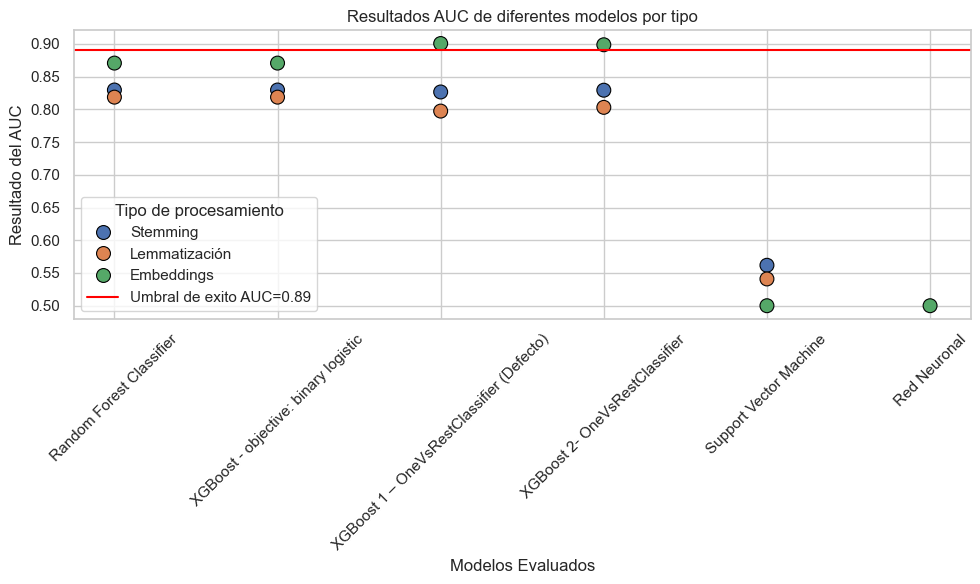

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define el diccionario con los resultados de AUC de diferentes modelos y su tipo
resultados = {
    'Modelo': ['Random Forest Classifier' , 'XGBoost - objective: binary logistic' , 'XGBoost 1 – OneVsRestClassifier (Defecto)', 'XGBoost 2- OneVsRestClassifier', 'Support Vector Machine',
               'Random Forest Classifier' , 'XGBoost - objective: binary logistic' , 'XGBoost 1 – OneVsRestClassifier (Defecto)', 'XGBoost 2- OneVsRestClassifier',  'Support Vector Machine',
               'Random Forest Classifier' , 'XGBoost - objective: binary logistic' , 'XGBoost 1 – OneVsRestClassifier (Defecto)', 'XGBoost 2- OneVsRestClassifier', 'Red Neuronal', 'Support Vector Machine'],
    'AUC': [0.8295, 0.8295, 0.8265, 0.8292,    0.5618,
            0.8186, 0.8186,0.7973,0.8030,     0.5409,
            0.8706, 0.8706, 0.9005, 0.8986, 0.5, 0.5],
    'Tipo': ['Stemming', 'Stemming', 'Stemming', 'Stemming', 'Stemming',
             'Lemmatización','Lemmatización','Lemmatización','Lemmatización', 'Lemmatización',
             'Embeddings','Embeddings','Embeddings','Embeddings','Embeddings','Embeddings']
}

# Convierte el diccionario en un DataFrame de Pandas
df = pd.DataFrame(resultados)

# Trazar la gráfica consolidada de puntos utilizando Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Modelo', y='AUC', hue='Tipo', s=100, edgecolor = "black")
plt.axhline(y=0.89, color='red', linestyle='-', label='Umbral de exito AUC=0.89')
plt.title('Resultados AUC de diferentes modelos por tipo')
plt.xlabel('Modelos Evaluados')
plt.ylabel('Resultado del AUC')
plt.legend(title='Tipo de procesamiento')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

A continuacion se presenta la tabla resumen de lo modelos evaluados:

In [4]:
# Convierte el diccionario en un DataFrame
df1 = pd.DataFrame(resultados)
df_AUC = df1.sort_values(by='AUC', ascending=False)
# Imprime el DataFrame
df_AUC

,Modelo,AUC,Tipo
12,XGBoost 1 – OneVsRestClassifier (Defecto),0.9005,Embeddings
13,XGBoost 2- OneVsRestClassifier,0.8986,Embeddings
10,Random Forest Classifier,0.8706,Embeddings
11,XGBoost - objective: binary logistic,0.8706,Embeddings
0,Random Forest Classifier,0.8295,Stemming
1,XGBoost - objective: binary logistic,0.8295,Stemming
3,XGBoost 2- OneVsRestClassifier,0.8292,Stemming
2,XGBoost 1 – OneVsRestClassifier (Defecto),0.8265,Stemming
5,Random Forest Classifier,0.8186,Lemmatización
6,XGBoost - objective: binary logistic,0.8186,Lemmatización
